## Project- AirFares
--- -------------------

### A. Introduction
--- -------------------

This project studies the german domestic airfares during the period 25-10-2019 to 24-04-2020 between major airports in Germany. The aim of the project is to apply the techniques of machine learning on the dataset and understand the trends in pricing with respect to the various features such the booking date, departure & arrival cities, departure time etc. 
#### B. Details of dataset:
-- -------------------
1. Source: [https://www.kaggle.com/datasets/darjand/domestic-german-air-fares](https://www.kaggle.com/datasets/darjand/domestic-german-air-fares)
2. Generation mode: web scraping
3. Time period considered: 25-10-2019 to 24-04-2020 (6 months).
4. Total entries: 63,000
5. Features:
    * departure_city: The city from which the flight departs.
    * arrival_city: The city to which the flight arrives.
    * scrape_date: The date when flight price information was retrieved.
    * departure_date: The departure date of the flight (25-10-2019 to 24-04-2020).
    * departure_date_distance: How far in advance (e.g., "1 week") the flight was booked.
    * departure_time: The departure time of the flight.
    * arrival_time: The arrival time of the flight.
    * airline: The airline that operates the flight.
    * stops: The number of layovers or stops during the flight.
    * price (€): The price of the flight ticket in Euros.

#### C. Imports:
-- ----------

In [4]:
#imports
import numpy as np
import pandas as pd
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split, cross_val_score, KFold,GridSearchCV, learning_curve
import sklearn.feature_extraction.text as text
import sklearn.naive_bayes as nb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from datetime import datetime
import holidays
import time
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_rows', 20)


#### D. Load the dataset:
-- ------------------

In [5]:
#Load the data set
df = pd.read_csv('./data/German Air Fares.csv');

#### E. Data Understanding:
-- ----------------------

##### E.1 Basic statistics:

In [6]:
#Basic statistics
df.shape;                                           #--> (62626, 10)
df.info();df.isna().sum();                          #--> (No null objects)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62626 entries, 0 to 62625
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   departure_city           62626 non-null  object
 1   arrival_city             62626 non-null  object
 2   scrape_date              62626 non-null  object
 3   departure_date           62626 non-null  object
 4   departure_date_distance  62626 non-null  object
 5   departure_time           62626 non-null  object
 6   arrival_time             62626 non-null  object
 7   airline                  62626 non-null  object
 8   stops                    62626 non-null  object
 9   price (€)                62626 non-null  object
dtypes: object(10)
memory usage: 4.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62626 entries, 0 to 62625
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 

##### E.2 Understanding departure and arrival cities
-- ----------------------

In [7]:
df.departure_city.unique();
# a. Extract departure city name, discard shortform (e.g. DUS Düsseldorf -> Düsseldorf)
df['departure_city'] = df['departure_city'].astype(str).apply(lambda x: x.split()[1] if ' ' in x else x)

df.arrival_city.unique();
# b. Extract arrival city name, discard shortform (e.g. DUS Düsseldorf -> Düsseldorf)
df['arrival_city'] = df['arrival_city'].astype(str).apply(lambda x: x.split()[1] if ' ' in x else x)

# c. Replace departure & arrival cities with their respective rankings
airport_ranking = pd.read_csv("./data/German Airport Ranking.csv")
airport_ranking_dict = dict(
    zip(airport_ranking['Airport'], airport_ranking['Rank']))

df['departure_city'] = df['departure_city'].map(airport_ranking_dict)
df['arrival_city'] = df['arrival_city'].map(airport_ranking_dict)

##### E.2 Conclusion: 
* **ToDos:**
    * *A histogram showing distribution of departure and arrival cities would be interesting.*</font>

##### E.3 Understanding departure and scrape dates
-- ----------------------

In [8]:
# a. Departure dates: Find the departure date frequencies: How spread are they?
dep_dates = pd.to_datetime(df['departure_date'], dayfirst=True);
dep_dates = sorted(dep_dates.unique()); 
dep_dates = pd.Series(dep_dates);
dep_dates.shape;                                    
dep_dates.diff(periods=1).unique();        

# b. Scrape dates: Find the scrape date frequencies: How spread are they?
scrape_dates = pd.to_datetime(df['scrape_date'], dayfirst=True);
scrape_dates = sorted(scrape_dates.unique()); 
scrape_dates = pd.Series(scrape_dates);
scrape_dates.shape;                                    
scrape_dates.diff(periods=1).unique();
# -------------------------------------------------------
# c. Convert all date data into date-time format
df.departure_date = pd.to_datetime(df.departure_date, dayfirst=True);
df.scrape_date = pd.to_datetime(df.scrape_date, dayfirst=True);

# c. Sort the dataframe according to departure dates
df.sort_values(by='departure_date', inplace = True)
#print('Dataframe sorted according to departure date: ',df.departure_date.is_monotonic_increasing); #-> True

#--> Additionally, it was verified that there are no illegal date values.

##### E3: Conclusion: 
* **Departure dates:**
    * 42 unique departure dates
    * departure date frequencies are not unique -> ['1 days', '11 days', '5 days', '44 days', '85 days']
* **Scrape dates:**
    * scrape date frequencies are only from 18-24.10.2019
    * scrape date frequencies are unique -> 1 day

##### E.4 Understanding departure_date_distance
-- ----------------------

In [9]:
df.departure_date_distance.value_counts();           
#--> 
# 6 months    12672
# 6 weeks     11222
# 1 month     10092
# 1 week       9949
# 3 month      9748
# 2 weeks      7850
# 2 week       1093

# Replace vague departure_date_distance (weeks, months etc.) with differences as days 
df.departure_date_distance =  (df['departure_date'] - df['scrape_date']).dt.days

##### E.5 Understanding departure and arrival times
-- ----------------------

In [10]:
# a. Uniformize time formats ('Uhr', am/pm) into xx:xx 24-hour format
def convert_to_24_hour_format(time_str):
    if 'Uhr' in time_str:
        return datetime.strptime(time_str, '%H:%M Uhr').strftime('%H:%M')
    else:
        return datetime.strptime(time_str, '%I:%M%p').strftime('%H:%M')

# Convert departure time column to 24-hour format
df['departure_time'] = df['departure_time'].apply(convert_to_24_hour_format)
df['arrival_time'] = df['arrival_time'].apply(convert_to_24_hour_format)

# Strip only the hour (to make matters simple)
df['departure_time_hour'] = df['departure_time'].apply(lambda x: int(x.split(':')[0]))

##### E.6 Understanding Airlines
-- ---------------------------------------------

In [11]:
# a. Drop rows with 'Mehrere Fluglinien' and 'Multiple airlines'

df = df[~df['airline'].isin(['Mehrere Fluglinien', 'Multiple Airlines'])]
df['airline'] = df['airline'].replace('easyJet', 'EasyJet')

# b. Convert airlines into their respective ranks (numerical representation)
airport_ranking = pd.read_csv("./data/Airline Ranking.csv")
Airline_ranking_dict = dict(
    zip(airport_ranking['airline'], airport_ranking['rank']))

df['airline'] = df['airline'].map(Airline_ranking_dict)

##### E.6 Conclusion:
* **Airlines:**
    * There were 69 'Mehrere Fluglinien' and 153 'Multiple Airlines', these entries were removed.    

##### E.7 Understanding stops
---------------------------------------------

In [12]:
# Stops are converted into numerical values
# 0, 1 and 2 stops.
def countStops(stop):
    if 'direct' in stop:
        return 0
    elif '1' in stop:
        return 1
    elif '2' in stop:
        return 2
    
df['stops'] = df['stops'].apply(countStops)

##### E8. Understanding prices
--------------------------


In [13]:
# a. Rename 'price (€)' to 'price'
df = df.rename(columns={'price (€)': 'price'});

# b. format into int properly
df['price'] = df['price'].str.replace(',', '').astype(int)

##### E.8 Conclusion:
* prices are, of course, the target value

### F. New Features:
-- -----------

##### F.1: Departure weekdays

In [14]:
#  week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6. 
if 'departure_weekday' not in df.columns:
    df.insert(5,'departure_weekday', df.departure_date.dt.weekday)

##### F.2: days_until_a_holiday

In [15]:
# Create a holidays list for Germany for the years 2019 & 2020.
# Only the national holidays as provided by the holidays library are taken into account. They are:
# date	holiday
# 0	    2019-01-01	Neujahr
# 1	    2019-04-19	Karfreitag
# 2	    2019-04-22	Ostermontag
# 3	    2019-05-01	Erster Mai
# 4	    2019-05-30	Christi Himmelfahrt
# 5	    2019-06-10	Pfingstmontag
# 6	    2019-10-03	Tag der Deutschen Einheit
# 7	    2019-12-25	Erster Weihnachtstag
# 8	    2019-12-26	Zweiter Weihnachtstag
#----------------------------------------
# 9	    2020-01-01	Neujahr
# 10	2020-04-10	Karfreitag
# 11	2020-04-13	Ostermontag
# 12	2020-05-01	Erster Mai
# 13	2020-05-21	Christi Himmelfahrt
# 14	2020-06-01	Pfingstmontag
# 15	2020-10-03	Tag der Deutschen Einheit
# 16	2020-12-25	Erster Weihnachtstag
# 17	2020-12-26	Zweiter Weihnachtstag

holiday_list = list(holidays.Germany(years=[2019, 2020]).items())

holidays_df = pd.DataFrame(holiday_list, columns=['date','holiday'])
holidays_df.date = pd.to_datetime(holidays_df.date)

# Sort holidays_df by date
holidays_df = holidays_df.sort_values(by='date')

# Define a function to find the next holiday
def find_next_holiday(departure_date):
    return holidays_df[holidays_df['date'] >= departure_date].iloc[0]['date']

# Apply the function to get the 'next_holiday'
df['next_holiday'] = df['departure_date'].apply(find_next_holiday)

# Calculate the difference between the two dates to get the 'days_until_holiday'
df['days_until_holiday'] = (df['next_holiday'] - df['departure_date']).dt.days

##### F.3: travel_time

In [16]:
# Calculate the difference between departure and arrival times in hours
df['travel_time'] = (pd.to_datetime(df['arrival_time'], format='%H:%M') - pd.to_datetime(df['departure_time'], format='%H:%M')).dt.total_seconds() / 3600

# If travel time is negative, add 24 hours
df['travel_time'] = df['travel_time'].apply(lambda x: x + 24 if x < 0 else x)

# Normalize the travel time
df['travel_time'] =  df['travel_time'].apply(lambda x: round(x, 2))


### G. Features + Y Dataframe:
-- -----------

In [17]:
df = df.drop(['scrape_date', 'departure_date', 'next_holiday', 'departure_time', 'arrival_time'],axis=1)
df = df[['departure_city', 'arrival_city',	'departure_date_distance',	'departure_weekday', 'departure_time_hour', 'travel_time', 'days_until_holiday', 'airline',	'stops', 'price']]

### H. Optional: Save dataframe as excel file
-- -----------

In [18]:
# df.to_excel('./data/dataframe_airfares.xlsx', index=False)

### I. Split data into training and test data sets
-- -----------

In [19]:
#df = np.log1p(df)

# x -> Feature variables
x = df.iloc[:,0:-1]

# y -> Target variable
y = df['price'];

# selected_features = ["departure_date_distance", "departure_weekday", "departure_time_hour", "travel_time", "days_until_holiday", "airline", "stops" ]
# x_features_selected = x[selected_features]

# Split into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

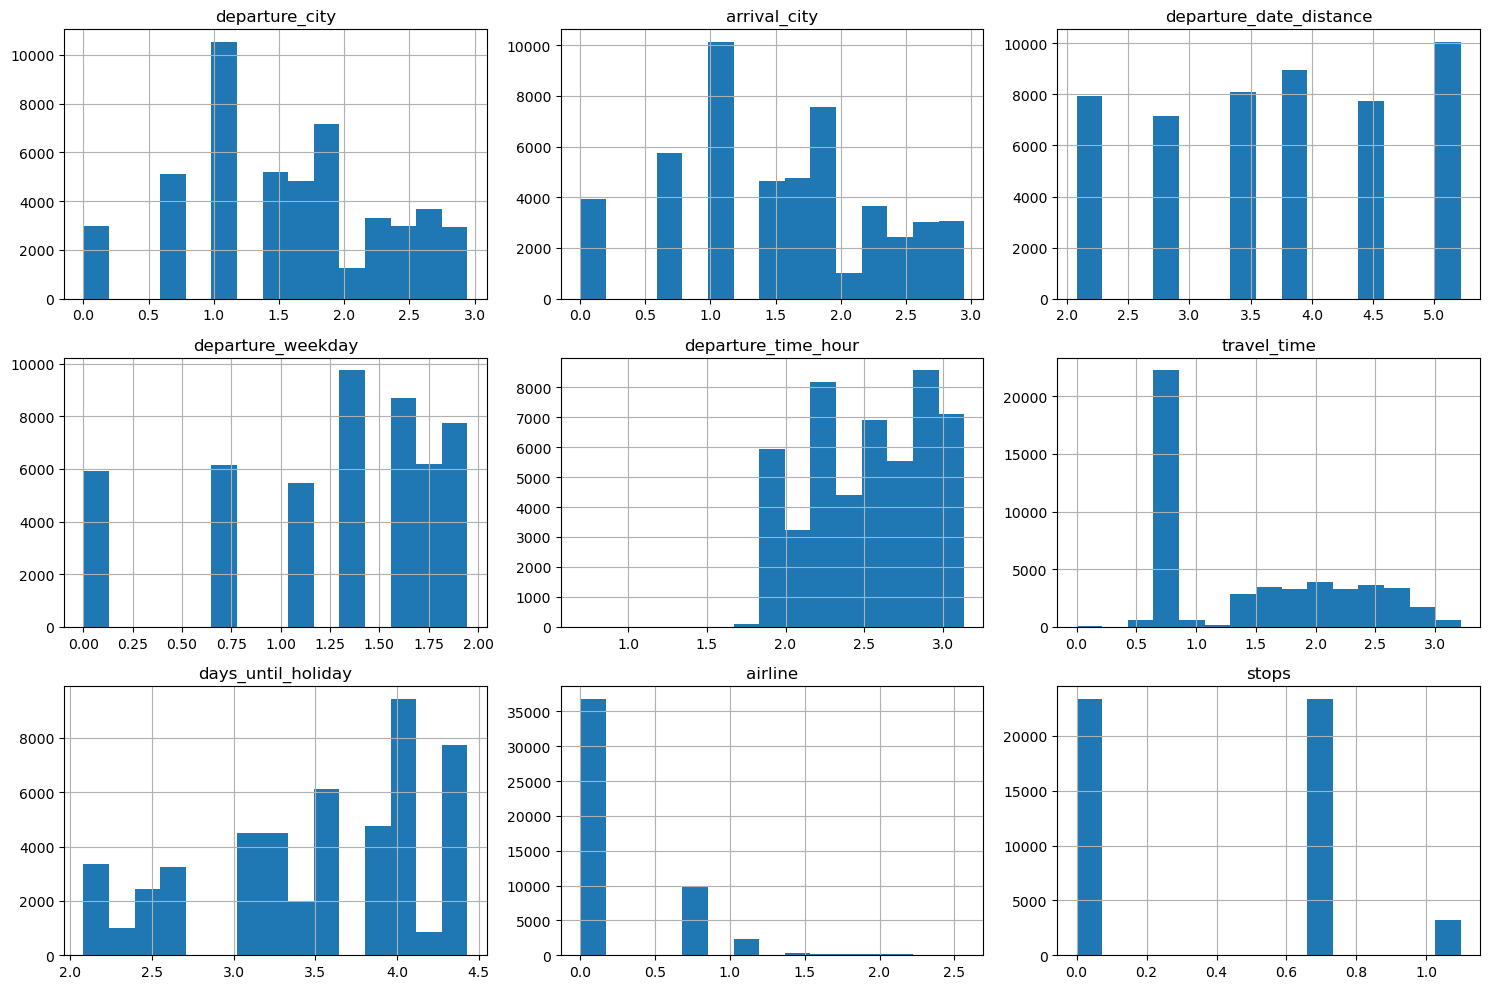

In [20]:
# Histograms of all features
x_train.hist(bins=15, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [21]:
# Statistical analysis of dependent variable.
mean_y = np.mean(y)
median_y = np.median(y)
mode_y = stats.mode(y)
std_dev_y = np.std(y)

print(f"Mean of y: {mean_y}")
print(f"Median of y: {median_y}")
print(f"Mode of y: {mode_y.mode}")
print(f"Standard deviation of y: {std_dev_y}")

Mean of y: 214.2801262739568
Median of y: 162.5
Mode of y: 100
Standard deviation of y: 169.50671229479843


### J. Regression
-- -----------

##### J.1.1 Linear Regression

In [22]:
#model
LR = LinearRegression()
# fitting the training data
LR.fit(x_train,y_train)

y_pred =  LR.predict(x_test)

The initial results are quick checked against the following values:
1. Mean squared Error / Root mean squared Error: 
    Gives the mean squared/ root mean squared error regression loss.
    $$MSE = \frac{1}{n}\sum_{i=1}^{n}(Y_i - \hat{Y_i})^2$$
    $$RMSE = \sqrt{MSE}$$

2. $R^2$ score:
The (coefficient of determination) regression score function.

    Best possible score is 1.0 and it can be negative when the model is arbitrarily worse. In the general case when the true y is non-constant, a constant model that always predicts the average y disregarding the input features would get a score of 0.0.

    $$R^2 = 1 - \frac{SSR}{SST}$$

    SSR	=	Sum of Squares Residual
    $$SSR = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

    Where:
    - $n$ is the number of data points.
    - $y_i$ is the observed value of the dependent variable for the \(i\)th data point.
    - $\hat{y}_i$ is the predicted value of the dependent variable for the \(i\)th data point based on the regression model.

    SST	=	Sum of Squares Total

    $$SST = \sum_{i=1}^{n} (y_i - \bar{y})^2$$

    Where:
    - $n$ is the number of data points.
    - $y_i$ is the observed value of the dependent variable for the \(i\)th data point.
    - $\bar{y}$ is the mean (average) of the observed values of the dependent variable across all data points.


##### J.1.2 Linear Regression - validation

In [23]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

naive_prediction = np.full_like(y_test, np.mean(y_train))
naive_mse = mean_squared_error(y_test, naive_prediction)
naive_rmse = np.sqrt(naive_mse)
naive_r2 = r2_score(y_test, naive_prediction)
naive_std_dev = np.std(y_test)

print(f'Naive MSE: {naive_mse}')
print(f'Naive RMSE: {naive_rmse}')
print(f'Naive std deviation: {naive_std_dev}')
print(f'Naive R2 Score: {naive_r2}')
print();
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared R2 Score: {r2}')

Naive MSE: 29285.806185401812
Naive RMSE: 171.1309620886934
Naive std deviation: 171.1295257401572
Naive R2 Score: -1.6786753289421696e-05

Mean Squared Error: 19229.7194792195
Root Mean Squared Error: 138.6712640716147
R-squared R2 Score: 0.343366470363316


Obviously, the model is too simple and the score values are too low and not much different from naive predictions!

##### J.2.1 Polynomial Regression

Now, we try to fit the data based on a polynomial regression model.
Polynomial regression is an extension of linear regression, where the relationship between the dependent variable and the independent variables are modeled as an nth-degree polynomial function to better capture the model complexity.
i.e,
$$Y_(pred) = a_0 + a_1x + a_2x^2 + ... + a_nx^n + \epsilon$$
The degree of the polynomial is a hyperparameter which is found by the minimization of the bayesian information criteria (BIC).
BIC is a measure of the trade-off between the goodness-of-fit and the complexity of a regression model. BIC penalizes models that have too many parameters and favors models that have higher likelihoods. BIC is calculated as: 
$$BIC = -2 * log(L) + k * log(n)$$
where:
- L is the likelihood of the model
- k is the number of parameters, and
- n is the sample size.

Assuming a normal distribution of model error, for a polynomial regression model, it can be simplififed as:
$${\displaystyle \mathrm {BIC} =n\ln(MSE)+k\ln(n)\ }$$
where:
- n is the number of samples
- k is the number of parameters and,
- MSE the mean square error.

##### J.2.2 Optimal degree of polynomial

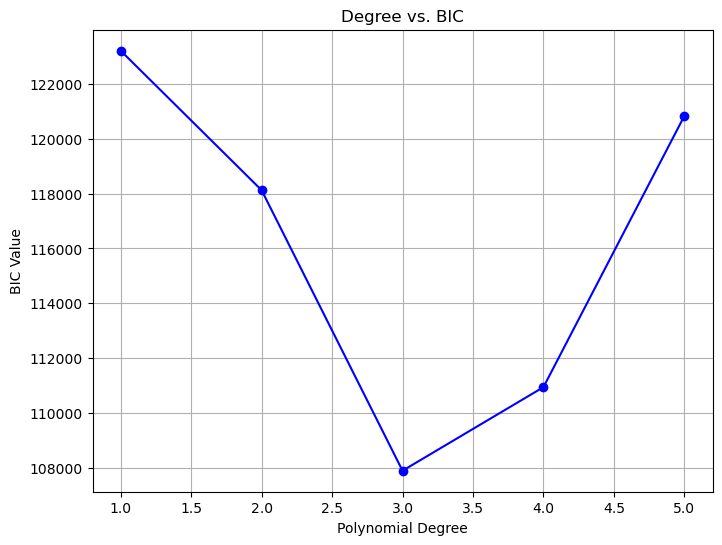

In [24]:
# Find the optimal degree of the polynomial
# -----------------------------------------

# Create a range of polynomial degrees to test
degrees = np.arange(1, 6)

# Initialize lists to store BIC values
bic_values = []

for degree in degrees:
    # Create Polynomial Features
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(x_train)
    X_test_poly = poly.transform(x_test)

    # Initialize and train the polynomial regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Make predictions using the trained model on the test data
    y_pred = model.predict(X_test_poly)

    # Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)

    # Count the number of parameters (features, interactions, and intercept)
    num_parameters = X_train_poly.shape[1]

    # Calculate the BIC
    n = len(y_test)  # Number of data points (sample size)
    bic = n * np.log(mse) + num_parameters * np.log(n)
    
    bic_values.append(bic)

# Plot the degree vs. BIC
plt.figure(figsize=(8, 6))
plt.plot(degrees, bic_values, marker='o', linestyle='-', color='b')
plt.title('Degree vs. BIC')
plt.xlabel('Polynomial Degree')
plt.ylabel('BIC Value')
plt.grid(True)
plt.show()

degree = 3 is prefered, since it yields the lowet value of BIC!
Now, we proceed to training the model.

##### J.2.3 Polynomial Regression training

In [25]:
# Train the model 
# -----------------------------------------------

degree = 3  # You can adjust the degree as needed
poly = PolynomialFeatures(degree=degree)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

poly_regression_model = LinearRegression()
poly_regression_model.fit(x_train_poly, y_train)

y_pred = poly_regression_model.predict(x_test_poly)

##### J.2.4 Polynomial Regression- validation scores
Compare with validation scores: MSE, RMSE, $R^2$ score

In [26]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
y_pred_std_dev = np.std(y_pred)

naive_prediction = np.full_like(y_test, np.mean(y_train))
naive_mse = mean_squared_error(y_test, naive_prediction)
naive_rmse = np.sqrt(naive_mse)
naive_r2 = r2_score(y_test, naive_prediction)
naive_std_dev = np.std(y_test)

print(f'Naive MSE: {naive_mse}')
print(f'Naive RMSE: {naive_rmse}')
print(f'Naive R2 Score: {naive_r2}')
print(f'Naive std deviation: {naive_std_dev}')
print();
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')
print(f'y_pred_std deviation: {y_pred_std_dev}')

Naive MSE: 0.5422987021094265
Naive RMSE: 0.7364093305420747
Naive R2 Score: -0.0002024861563343361
Naive std deviation: 0.7363347855152298

Mean Squared Error: 4809.760084582869
Root Mean Squared Error: 69.35243387641755
R2 Score: 0.8357620481953347


The values are satisfactory. $R^2$ score of 0.83 indicates about 83% of the variation of the dependent vraiable can be explained by the independent model varaibles, showing a good fit of the model!

##### J.2.5 Further validation

##### J.2.5.1 Cross validation

In [27]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
scores = cross_val_score(poly_regression_model, x_train_poly, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_avg_mse = -np.mean(scores);
cv_avg_rmse = np.sqrt(cv_avg_mse)

print(f"CV avg_MSE: {cv_avg_mse}")
print(f"CV avg_RMSE: {cv_avg_rmse}")

CV avg_MSE: 4933.412537395897
CV avg_RMSE: 70.23825551219149


The CV RMSE also indicate good validation score!

##### J.2.5.2 Residual plots

Residual plots display the residual values (difference between observed values and predicted values) against the predicted values. The core ideas are:
1. Zero centricity:
    The residuals should be ideally randomly scattered around zero for the entire range of fitted values. This indicates that the residuals follow a normal distribution (as assumed) and that the degree of scattering is the same for all fitted values. The model’s predictions are correct on average rather than systematically too high or low.
2. Abscence of patterns:
    Structured patterns in the residual plot indicates modeling issues

ModuleNotFoundError: No module named 'statsmodels'

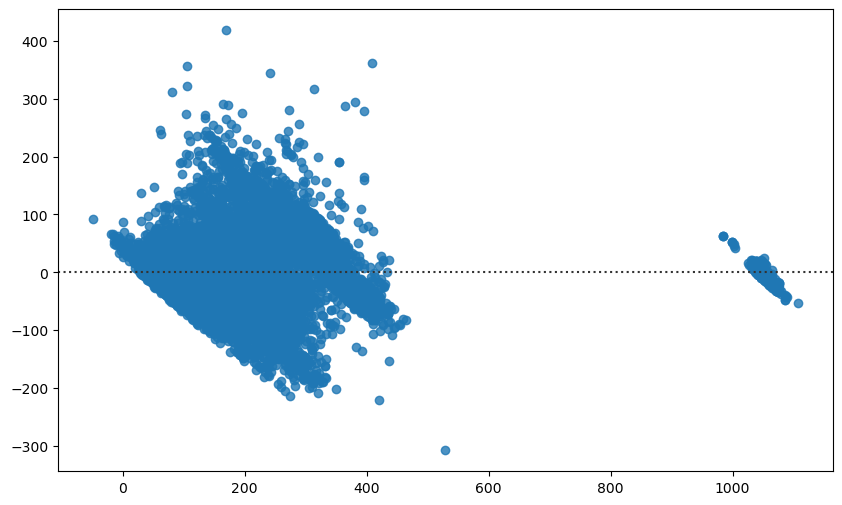

In [29]:
# Calculate residuals
residuals = y_test - y_pred

# Plotting the residuals
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='blue', linestyle='--')
plt.show()

The residual plots display a good trend in prediction!

The distribution of residual plots are checked again to confirm the assumption of normal distribution.

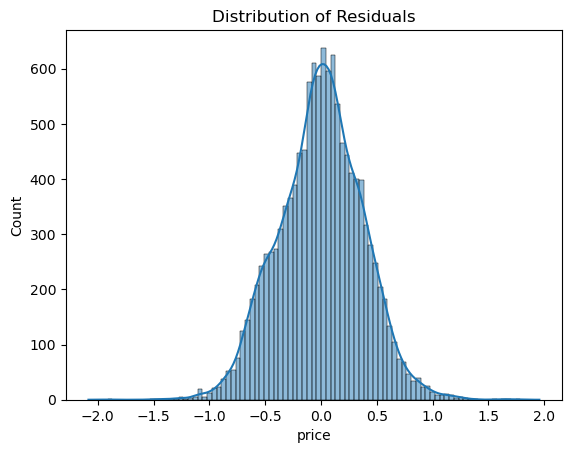

Mean of residuals: -0.2828748491991494
Standard deviation of residuals: 69.35185697876133


In [30]:
sns.histplot(
    residuals, kde=True, kde_kws=dict(cut=3)
)
plt.title('Distribution of Residuals')
plt.show()

# Calculate mean and standard deviation of residuals
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)

print(f"Mean of residuals: {mean_residuals}")
print(f"Standard deviation of residuals: {std_residuals}")

The distribution indicates that it is close to the assumed normal distribution, but not exactly a normal distribution. This is further explored through the QQplots as shown below. 

##### J.2.5.3 QQ Plots

QQ plots or quantile plots compares the quantiles of two distributions, in this case, the normal distribtuion on X-axis and thh distribution of residuals on the Y-axis. They are useful in assessing whether the dataset (residuals) follows a specific theoretical probability distribution (normal distribution, here). Ideally, all the points should lie on a straight diagonal line from the bottom-left to the top-right of the plot, indicating the model closely follows the assumed distribution.

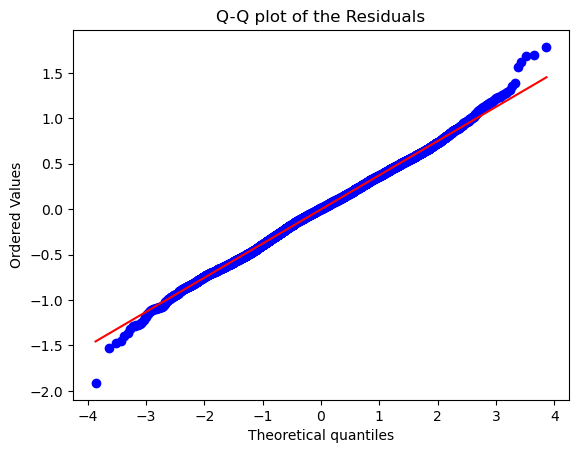

In [31]:
#QQ plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot of the Residuals')
plt.show()

It can be observed that the plot curves upwards (*right-skew/ positive skew*) slightly. 
This indicates that the number of larger observations are more than that is expected from a normal distribution. That is, the upper tail of the data’s distribution has been extended, relative to a normal distribution as evident from the residuals distribution plot.
This could be due to that the airfares dataset consists of skewed information. Since the data was scraped from a span of only 7 consecutive dates for a departure date set consisting of only 42 days and considers only local german airports, it is likey that the dataset has limited variablity in the lower-mid range of prices, with a few wide range of values on the upper side of prices.This can exhibit some positive skewness.

##### J.2.5.4 Scatter plot: Actual vs. predicted values

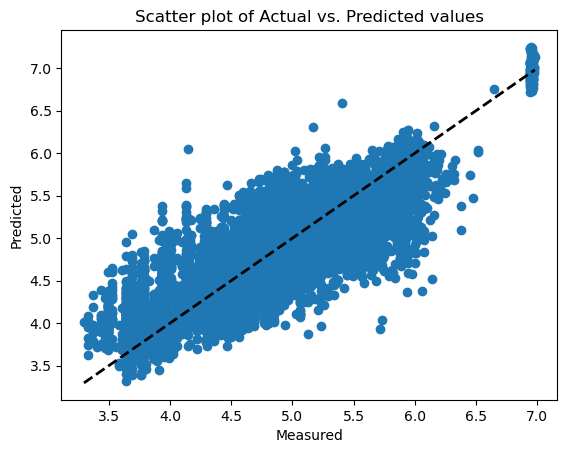

In [32]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Scatter plot of Actual vs. Predicted values')
plt.show()

### K. Regression tree
-- -----------

##### K.1 Making a regression tree from the data. Post pruning takes too much time for this example.

In [33]:
X = df.copy(deep=True)
y = X['price']
X.drop(columns='price', inplace=True)

(X_reg_train, X_reg_test, y_reg_train, y_reg_test) = ms.train_test_split(X, y, test_size=.2, random_state = 0)

regressor = DecisionTreeRegressor(random_state=0, max_depth=15, min_samples_leaf=20)
regressor.fit(X_reg_train,y_reg_train)
tmp_reg = list(zip(regressor.feature_names_in_, regressor.feature_importances_))

for i in tmp_reg:
    print(i)

pred = regressor.predict(X_reg_test)
mse_reg = mean_squared_error(y_reg_test, pred)
print("mean sqared error =", mse_reg)

mae_reg = mean_absolute_error(y_reg_test, pred)
print("mean absolute error =", mae_reg)

r2s = r2_score(y_reg_test, pred)
print("score =", r2s)

('departure_city', 0.2507903415110873)
('arrival_city', 0.29847602002449236)
('departure_date_distance', 0.03517340910766325)
('departure_weekday', 0.010522775784703555)
('departure_time_hour', 0.013966494108150646)
('travel_time', 0.007410473419308662)
('days_until_holiday', 0.011293022266687552)
('airline', 0.031638340433263766)
('stops', 0.34072912334464295)
mean sqared error = 2633.92894061237
mean absolute error = 31.35711072826031
score = 0.9062445444231073


This plot shows at which prices it is better at predicting the price.

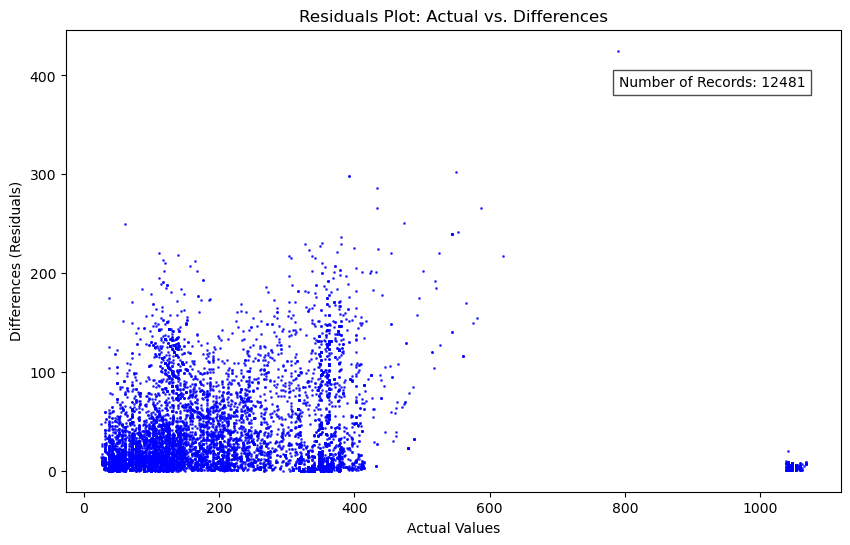

In [34]:
differences_reg = abs(pred - y_reg_test)

# Create a scatter plot of differences
plt.figure(figsize=(10, 6))
num_records = len(y_reg_test)
plt.text(max(y_reg_test), 400, f'Number of Records: {num_records}', ha='right',
         va='top', color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
plt.scatter(y_reg_test, differences_reg, color='blue', alpha=0.7, s=1)
plt.title('Residuals Plot: Actual vs. Differences')
plt.xlabel('Actual Values')
plt.ylabel('Differences (Residuals)')

plt.show()

##### K.2 Regression tree with only the most important data. Data with a feature importance below 0.01 were removed, to see how much difference they make.

In [35]:
X = df.copy(deep=True)
y = X['price']
X.drop(columns=['price','travel_time','departure_weekday','departure_time_hour','days_until_holiday','airline','departure_date_distance'], inplace=True)
(X_reg_train, X_reg_test, y_reg_train, y_reg_test) = ms.train_test_split(X, y, test_size=.2, random_state = 0)
regressor = DecisionTreeRegressor(random_state=0, max_depth=15)
#regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_reg_train,y_reg_train)
tmp_reg = list(zip(regressor.feature_names_in_, regressor.feature_importances_))
print(tmp_reg)

pred = regressor.predict(X_reg_test)
mse_reg = mean_squared_error(y_reg_test, pred)
print("mean sqared error =", mse_reg)

mae_reg = mean_absolute_error(y_reg_test, pred)
print("mean absolute error =", mae_reg)

r2s = r2_score(y_reg_test, pred)
print("score =", r2s)

[('departure_city', 0.2864763178461718), ('arrival_city', 0.3392665626320662), ('stops', 0.3742571195217619)]
mean sqared error = 4860.593457534473
mean absolute error = 49.08005862740865
score = 0.8269857827374569


Removing all but the most important features reduces the score only by 0.08.

##### K.3 Regression tree with only the most important data. This time with post pruning, to try to find a better solution.

In [36]:
X = df.copy(deep=True)
y = X['price']
X.drop(columns=['price','travel_time','departure_weekday','departure_time_hour','days_until_holiday','airline','departure_date_distance'], inplace=True)
(X_reg_train, X_reg_test, y_reg_train, y_reg_test) = ms.train_test_split(X, y, test_size=.2, random_state = 0)

regressor = DecisionTreeRegressor(random_state=0)

path = regressor.cost_complexity_pruning_path(X_reg_train, y_reg_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
parameters = {'ccp_alpha':ccp_alphas[:-1].tolist()}

gs = GridSearchCV(DecisionTreeRegressor(random_state=0), parameters, cv=10, refit=True)
gs.fit(X_reg_train,y_reg_train)

tree_best = gs.best_estimator_
tmp_reg = list(zip(tree_best.feature_names_in_, tree_best.feature_importances_))
print(tmp_reg)

pred = tree_best.predict(X_reg_test)
mse_reg = mean_squared_error(y_reg_test, pred)
print("mean sqared error =", mse_reg)

mae_reg = mean_absolute_error(y_reg_test, pred)
print("mean absolute error =", mae_reg)

r2s = r2_score(y_reg_test, pred)
print("score =", r2s)

[('departure_city', 0.2866968621755227), ('arrival_city', 0.3390905981504841), ('stops', 0.3742125396739932)]
mean sqared error = 4856.706713051694
mean absolute error = 49.0044592041914
score = 0.8271241325213388


This plot shows at which prices it is better at predicting.

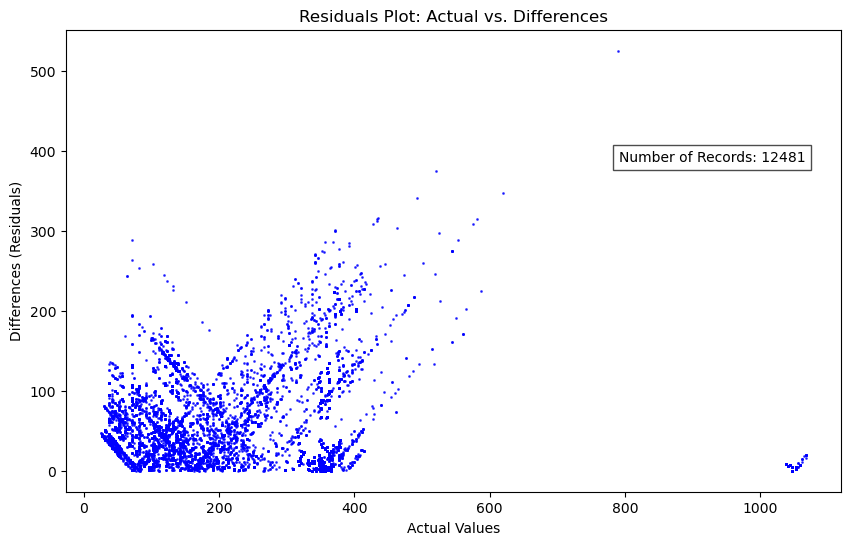

In [37]:
differences_reg = abs(pred - y_reg_test)

# Create a scatter plot of differences
plt.figure(figsize=(10, 6))
num_records = len(y_reg_test)
plt.text(max(y_reg_test), 400, f'Number of Records: {num_records}', ha='right',
         va='top', color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
plt.scatter(y_reg_test, differences_reg, color='blue', alpha=0.7, s=1)
plt.title('Residuals Plot: Actual vs. Differences')
plt.xlabel('Actual Values')
plt.ylabel('Differences (Residuals)')

plt.show()

Here the top part of the tree is shown.

<function matplotlib.pyplot.show(close=None, block=None)>

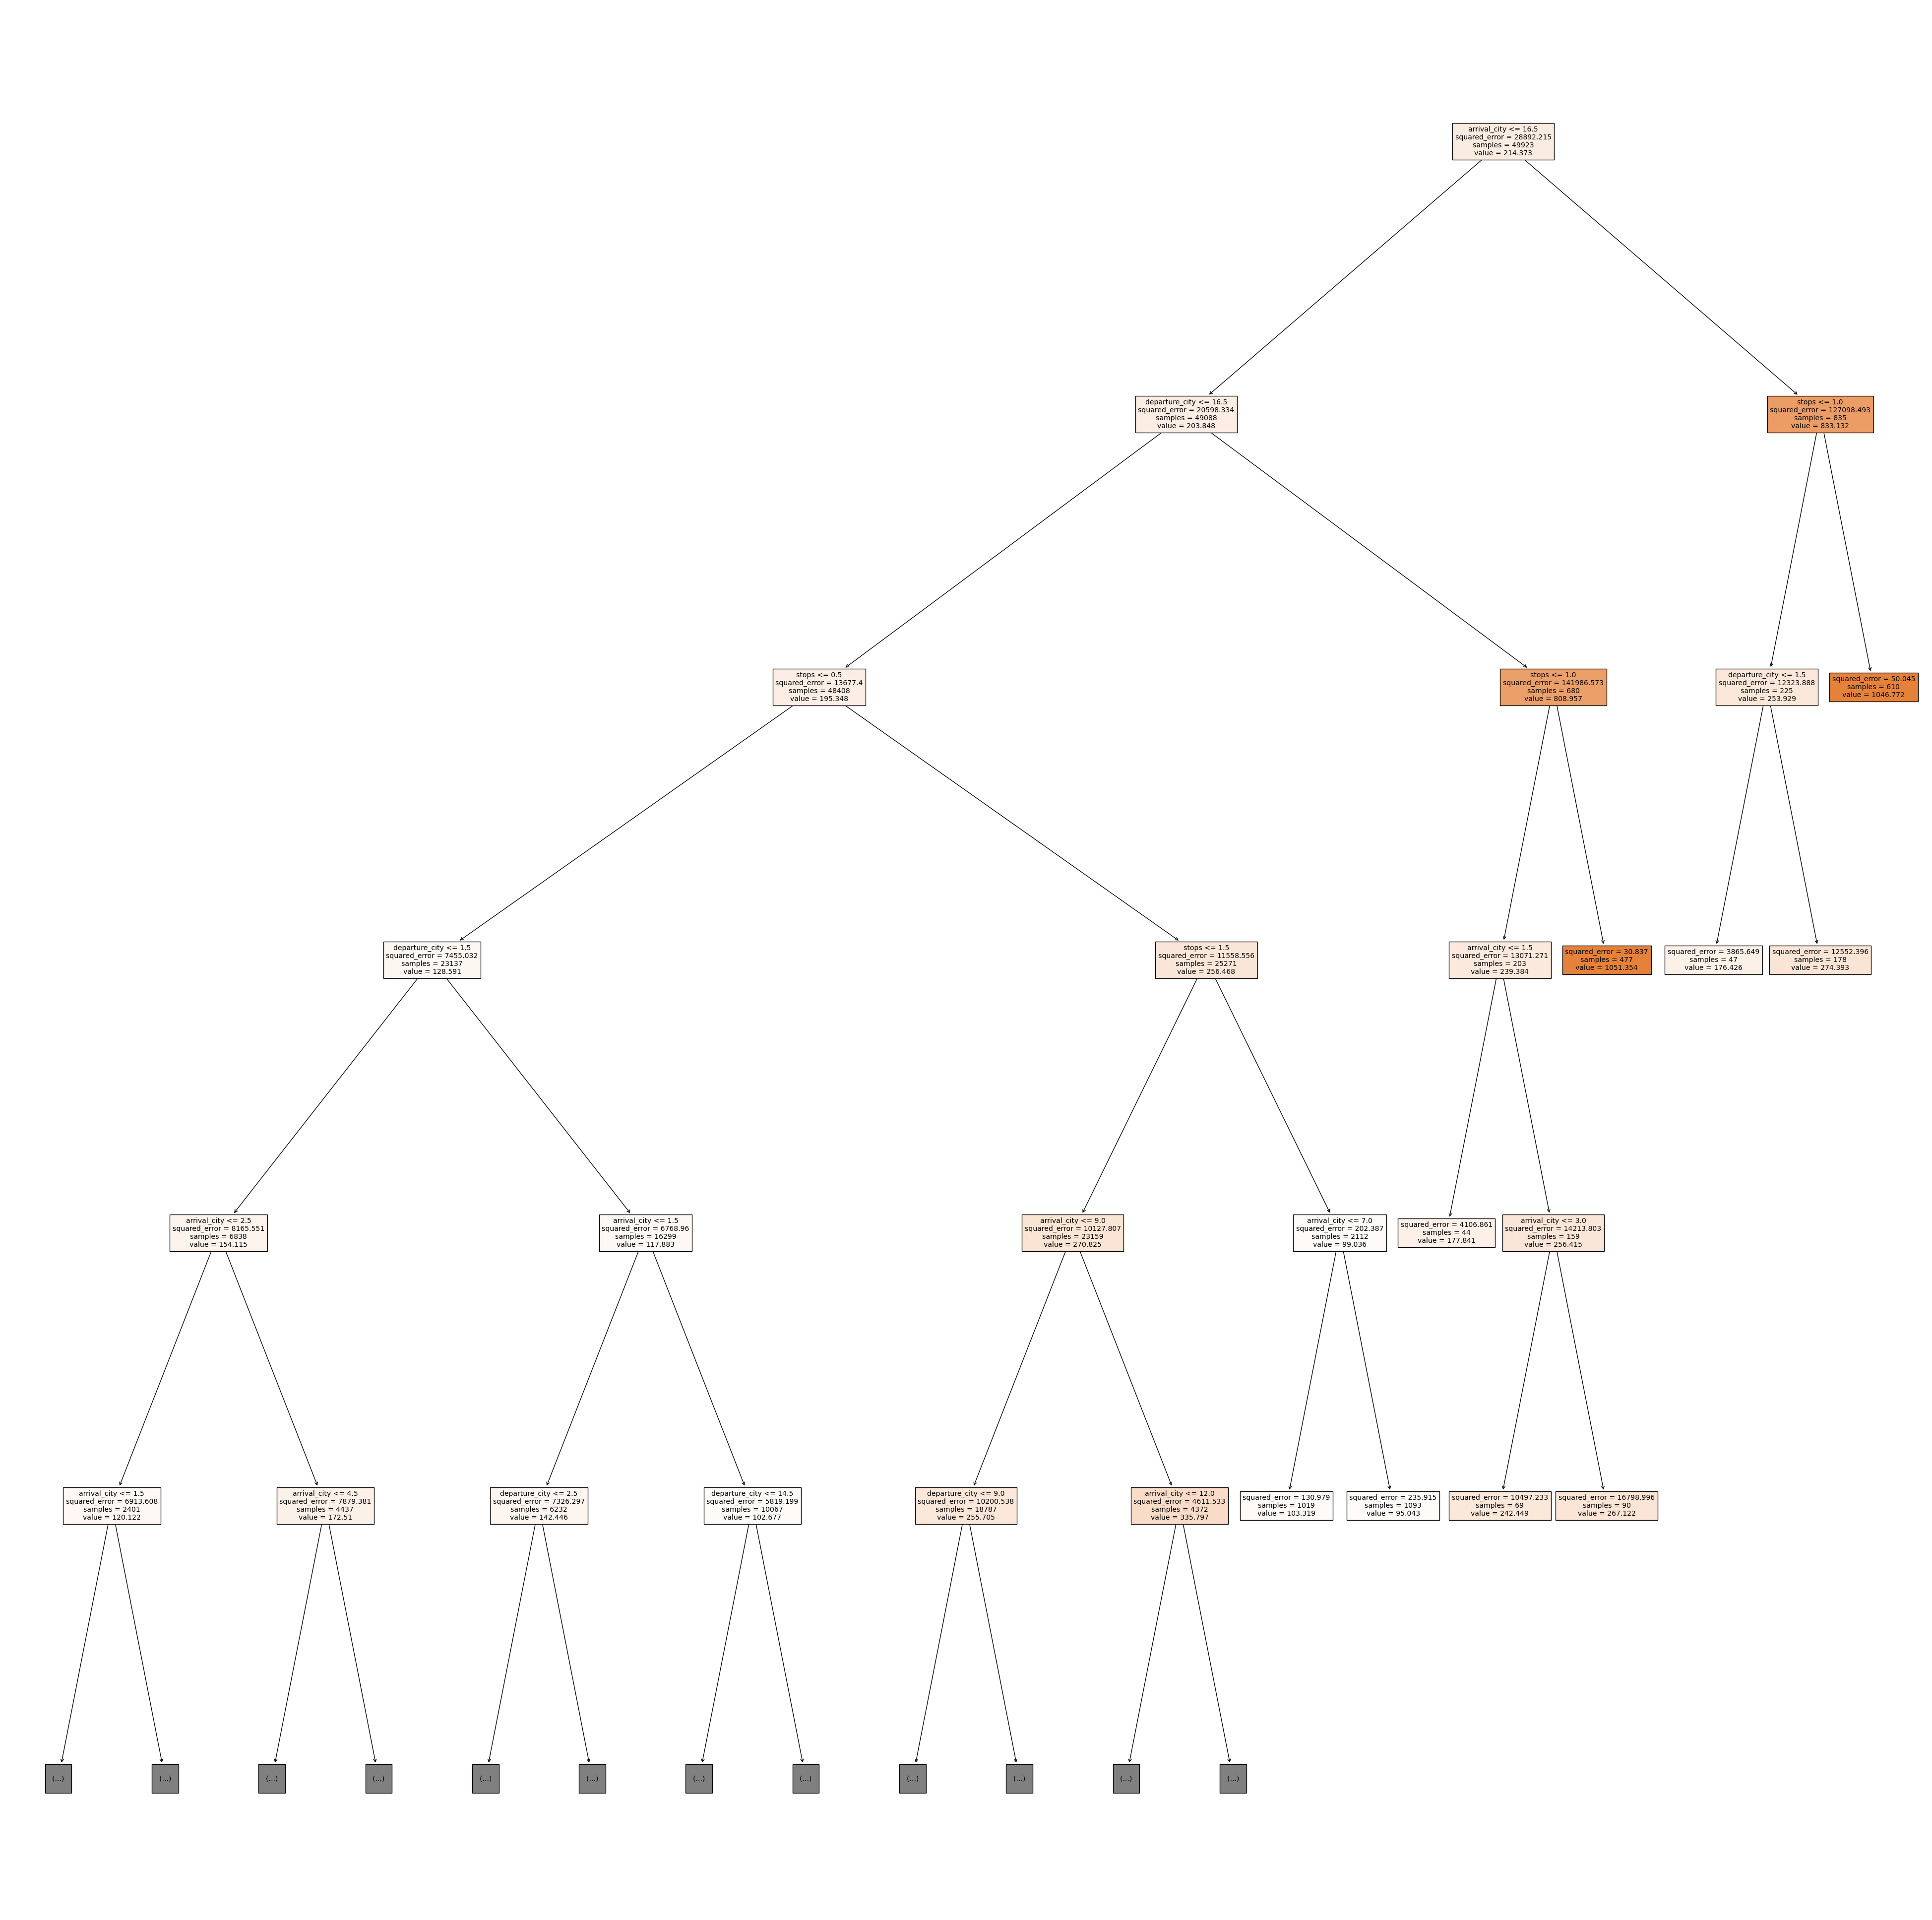

In [38]:
fig = plt.figure(figsize=(50,50))
text = tree.plot_tree(tree_best, 
                    feature_names=X.columns.to_list(), 
                    filled=True,
                    max_depth=5)
plt.show

### Conclusion:
- with the score of 0.90 Regression trees are good for predicting airfare prices
- removing all but the most important features only drops to a score of 0.82 this show how insignificant the other features are.

### L. Random Forests
-- ----

##### L.1 Seperate the data and prepare it

In [39]:
y = df['price']
X = df.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

##### L.2 Try to find the best n_estimators

1475.4071497193409 190


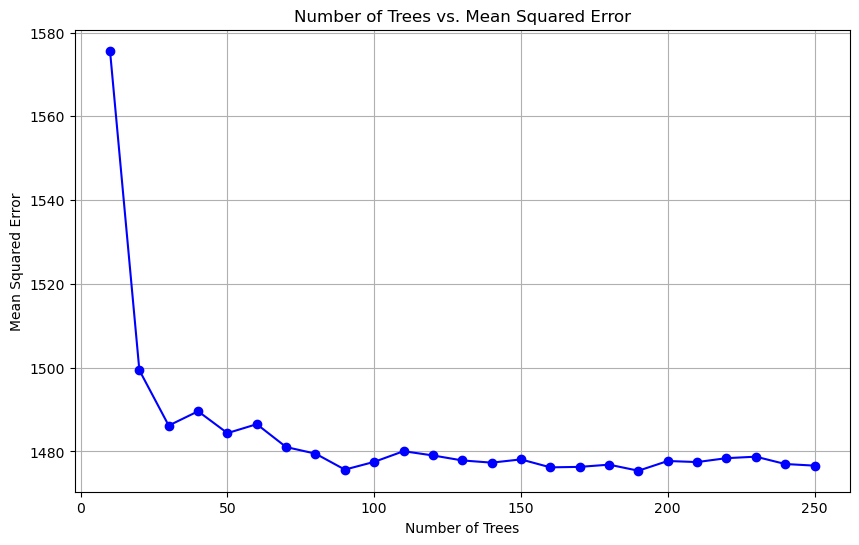

In [40]:
def find_n_estimators(min_splits=2):
    num_trees_list = []
    mse_list = []
    step = 10
    for i in range(10, 251, step):
        regressor = RandomForestRegressor(
            n_estimators=i, random_state=42, n_jobs=-1, min_samples_split=min_splits)

        # Train the regressor on the training data
        regressor.fit(X_train, y_train)

        # Make predictions on the testing set
        predictions = regressor.predict(X_test)

        mse = mean_squared_error(y_test, predictions)

        num_trees_list.append(i)
        mse_list.append(mse)
        
        if step > 50: step = 25
        if step > 200: step = 50
        
    print(min(mse_list), num_trees_list[mse_list.index(min(mse_list))])
    plt.figure(figsize=(10, 6))
    plt.plot(num_trees_list, mse_list, marker='o', linestyle='-', color='b')
    plt.title('Number of Trees vs. Mean Squared Error')
    plt.xlabel('Number of Trees')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    plt.show()


find_n_estimators()

Plot shows that the forest with 190 trees has the best result. So let us model it and visualize the predictions.

In [41]:
regressor = RandomForestRegressor(
    n_estimators=190, random_state=42, n_jobs=-3, oob_score=True)

# Train the regressor on the training data
regressor.fit(X_train, y_train)

# Make predictions on the testing set
predictions = regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(mse, r2)

1475.4071497193409 0.9496195560513329


##### L3. GridSearchCV to find best params

In [42]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the grid search object
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Perform the grid search
grid_search.fit(X, y)

scores = []

# Iterate over each score from the grid search
for score in grid_search.cv_results_['mean_test_score']:
    # Convert the score to positive
    score = -score
    # Add the score to the scores list
    scores.append(score)

# Print the best parameters and the corresponding oob score
print("Best Parameters: ", grid_search.best_params_)
print("Best OOB Score: ", grid_search.best_score_)
print("Best Model: ", grid_search.best_estimator_)
print("scores", scores)

Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best OOB Score:  -4709.336176823645
Best Model:  RandomForestRegressor(min_samples_split=5, n_estimators=190, n_jobs=-3,
                      oob_score=True, random_state=42)
scores [4737.497229628747, 4709.336176823645, 4752.210609578933, 4734.335557991586, 4736.697671465097, 4761.7382039378845, 4761.12329146633, 4761.12329146633, 4777.090088982496, 7322.212393658776, 7322.295301951995, 7322.340215491395, 7322.050773926001, 7322.050401614991, 7322.095879897439, 7322.809522757234, 7322.809522757234, 7322.816730256278, 5796.263136105164, 5791.825617675124, 5805.693568932204, 5792.173612647145, 5790.7715351749885, 5799.879613451521, 5800.19052276455, 5800.19052276455, 5783.230528555954, 5047.866775891964, 5032.764367226209, 5044.247615347207, 5054.588542402899, 5057.2735972632345, 5054.994164820901, 5071.755058977966, 5071.755058977966, 5067.768279126339]


We check again if the number of estimators changes with the new min_smaples_split

1476.5981150696216 190


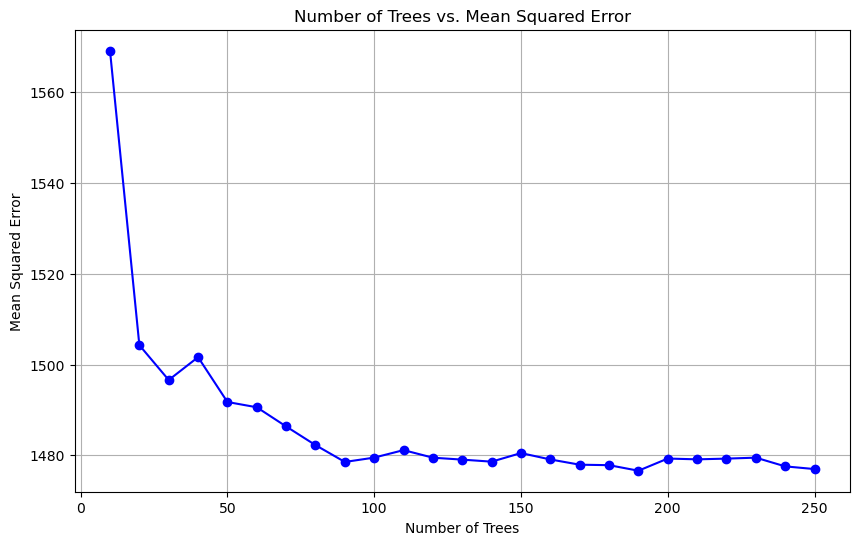

In [43]:
find_n_estimators(5)

Best regressor that we have so far.

In [44]:
regressor = RandomForestRegressor(
        n_estimators=190, random_state=42, n_jobs=-3, oob_score=True, min_samples_leaf=1, min_samples_split=5)

    # Train the regressor on the training data
regressor.fit(X_train, y_train)

# Make predictions on the testing set
predictions = regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(mse, r2)

1476.5981150696216 0.9495788883867591


##### L.4 Trying k fold cv to check for overfitting

In [45]:
num_folds = 10  # You can adjust this number based on your preference

# Create a cross-validation object (here using KFold)
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(regressor, X, y, cv=kf,
                            scoring='neg_mean_squared_error')

# Convert negative MSE to positive (as cross_val_score returns negative MSE)
cv_scores = -cv_scores

# Print the cross-validation scores
print("Cross-Validation Scores:")
print(cv_scores)

Cross-Validation Scores:
[1286.35552583 1468.35438773 1461.83283456 1439.20870134 1499.79429764
 1390.99144141 1377.90309223 1465.88296283 1451.31659431 1432.44922601]


##### L5. Learning Curve Visualization

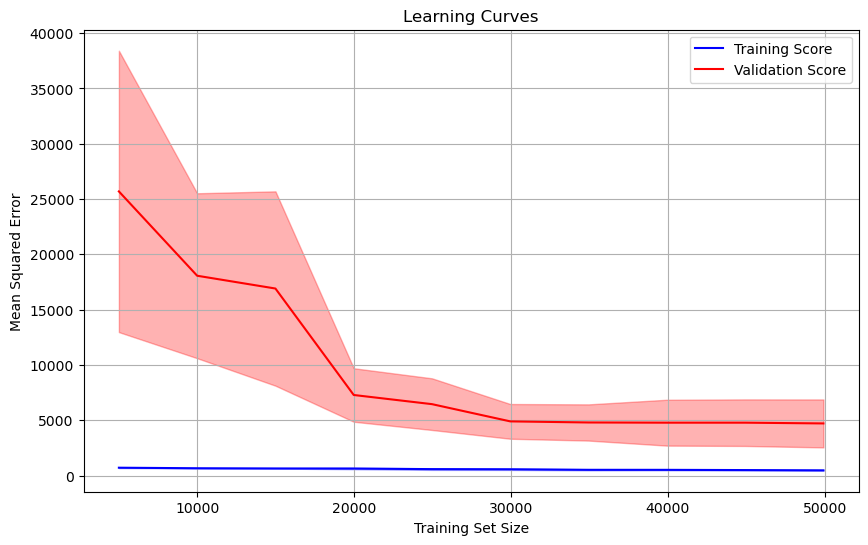

In [46]:
train_sizes, train_scores, val_scores = learning_curve(
    regressor, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

# Convert negative MSE to positive
train_scores = -train_scores
val_scores = -val_scores

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.3, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation Score', color='red')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.3, color='red')
plt.title('Learning Curves')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

Best model r2 score.

In [47]:
print("Best Model: ", grid_search.best_estimator_.oob_score_)

Best Model:  0.9523132886932745


Plotting the residuals,

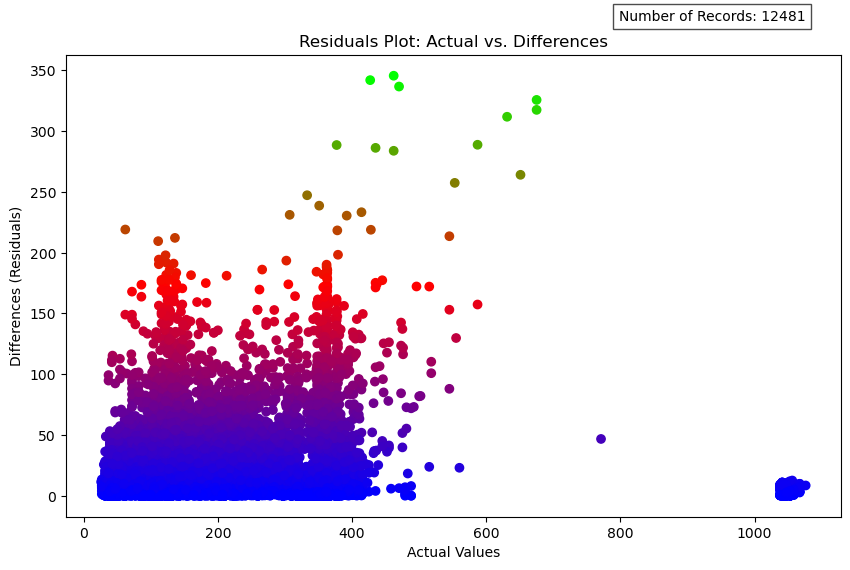

In [48]:
differences = abs(predictions - y_test)


# Calculate normalized differences for color mapping
normalized_differences = differences / differences.max()

# Map normalized differences to a colormap (e.g., red shades)
colors = plt.cm.brg(normalized_differences)

# Create a scatter plot of differences
plt.figure(figsize=(10, 6))
num_records = len(y_test)
plt.text(max(y_test), 400, f'Number of Records: {num_records}', ha='right',
         va='top', color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
plt.scatter(y_test, differences, color=colors, alpha=1)
plt.title('Residuals Plot: Actual vs. Differences')
plt.xlabel('Actual Values')
plt.ylabel('Differences (Residuals)')

plt.show()

##### L6. Weighted voting.

In [49]:
def calculate_oob_error(tree, X_train, y_train):
    # Predict on the out-of-bag samples
    oob_mask = np.ones(X_train.shape[0], dtype=bool)
    oob_mask[np.unique(np.where(tree.apply(X_train) == 0)[0])] = False
    oob_predictions = tree.predict(X_train[oob_mask])

    # Calculate OOB error (e.g., mean squared error)
    oob_error = mean_squared_error(y_train[oob_mask], oob_predictions)

    return oob_error

def custom_rf_predict(X, trees, weights):
    predictions = np.zeros(X.shape[0])
    total_weight = 0

    for tree, weight in zip(trees, weights):
        predictions += tree.predict(X) * weight
        total_weight += weight

    return predictions / total_weight

class w_rf(RandomForestRegressor):

    def predict(self, regressor, X_train, y_train):
        # Get the list of decision trees in the Random Forest
        trees = regressor.estimators_

        # Calculate the out-of-bag error for each tree
        oob_errors = [calculate_oob_error(
            tree, X_train, y_train) for tree in trees]

        # Normalize OOB errors to get weights
        weights = np.array(oob_errors)
        weights = 2 / (1 + weights)

        predictions = custom_rf_predict(X_train, trees, weights)
        
        return predictions

# Create a Random Forest Regressor with 100 trees
rf_regressor = RandomForestRegressor(n_estimators=190, random_state=42, min_samples_split=5, n_jobs=-3, oob_score=True)

X_train_np = X_train.values
y_train_np = y_train.values
X_test_np = X_test.values
y_test_np = y_test.values

# Train the initial Random Forest Regressor
rf_regressor.fit(X_train_np, y_train_np)

# Display the mean squared error before adjusting weights
print("Before Weight Adjustment - Mean Squared Error on Test Set:",
      mean_squared_error(y_test_np, rf_regressor.predict(X_test_np)))

# Adjust weights based on OOB errors
w_rf_regressor = w_rf(n_estimators=190, random_state=42, min_samples_split=5, n_jobs=-3, oob_score=True)

w_rf_regressor.fit(X_train_np, y_train_np)

# Display the mean squared error after adjusting weights
print("After Weight Adjustment - Mean Squared Error on Test Set:",
      mean_squared_error(y_test_np, w_rf_regressor.predict(w_rf_regressor, X_test_np, y_test_np)))

Before Weight Adjustment - Mean Squared Error on Test Set: 1476.5981150696216
After Weight Adjustment - Mean Squared Error on Test Set: 1474.4563702780629


### Conclusion
In this subsection, we trained a RF model with different setting and evaluated it:
* Used Random Forests to predict the price of flights.
* Explored different parameters and performed grid search to find the best model.
* Evaluated the model using mean squared error and R-squared score.
* Checked for overfitting using k-fold cross-validation and learning curves.
* Plotted the residuals to analyze the differences between actual and predicted values.
* Attempted weighted voting to improve the model's performance, which did not add any substantial accuracy benefits.